In [1]:
from tensorflow import depth_to_space
from keras.layers import Input, Conv2D, Add, BatchNormalization, LeakyReLU, PReLU, Dense, Flatten, Lambda
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.losses import mean_squared_error
from keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
def Upsample(x_in, num_filters):
    x = Conv2D(num_filters*4, (3,3), padding='same')(x_in)
    x = Lambda(lambda y: depth_to_space(y, 2))(x)
    x = PReLU(shared_axes=[1,2])(x)
    return x

In [3]:
def generator(num_filters, num_res_blocks):
    
    def res_block(x_in):
        x = Conv2D(num_filters, (3,3), padding='same')(x_in)
        x = BatchNormalization()(x)
        x = PReLU(shared_axes=[1,2])(x)
        x = Conv2D(num_filters, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x_in, x])
        return x
    
    x_in = Input(shape=(None, None, 3))
    x = Lambda(lambda x_in: x_in/255.0)(x_in)
    
    x = Conv2D(num_filters, (9,9), padding='same')(x)
    x = PReLU(shared_axes=[1,2])(x)
    temp = x
    
    for _ in range(num_res_blocks):
        x = res_block(x)
    
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([temp,x])
    
    x = Upsample(x, num_filters)
#     x = Upsample(x, num_filters)
    
    x = Conv2D(3, (9,9), padding='same', activation='tanh')(x)
    x = Lambda(lambda x_in: (x_in+1)*127.5)(x)
    
    return Model(x_in, x)

In [4]:
def discriminator(num_filters):
    
    def disc_block(x_in, num_filters, strides):
        x = Conv2D(num_filters, 3, padding='same', strides=strides)(x_in)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x
    
    x_in = Input(shape=(96,96,3))
    x = Lambda(lambda x_in: (x_in/127.5 - 1))(x_in)
    
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = disc_block(x, num_filters, 2)
    
    x = disc_block(x, num_filters*2, 1)
    x = disc_block(x, num_filters*2, 2)
    
    x = disc_block(x, num_filters*4, 1)
    x = disc_block(x, num_filters*4, 2)
    
    x = disc_block(x, num_filters*8, 1)
    x = disc_block(x, num_filters*8, 2)
    x = Flatten()(x)
    
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(x_in, x)

In [5]:
output_layer = 20
vgg19 = VGG19(include_top=False, weights='imagenet')
vgg = Model(vgg19.input, vgg19.layers[output_layer].output)

def content_loss(hr, sr):
    sr = preprocess_input(sr)
    hr = preprocess_input(hr)
    sr_features = vgg(sr)
    hr_features = vgg(hr)
    return mean_squared_error(sr_features, hr_features)

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step


In [6]:
d_opt = Adam(1e-4)
g_opt = Adam(3e-5)
directory = '../input/div2k_train_lr_bicubic_x4/DIV2K_train_LR_bicubic/X4/'

gen = generator(64, 5)
dis = discriminator(64)
dis.compile(d_opt, loss='binary_crossentropy')

dis.trainable = False
x_in = Input(shape=(48,48,3))
temp = gen(x_in)
x = dis(temp)
gan = Model(x_in, [x, temp])
gan.compile(g_opt, loss=['binary_crossentropy', content_loss], loss_weights=[0.006, 0.001])

In [7]:
def get_image(img_file, res, directory=directory):
        
        if res=='lr':
            target_size = (48, 48, 3)
        elif res=='hr':
            target_size = (96, 96, 3)
            
        temp = load_img(directory + img_file, target_size=target_size)
        temp = img_to_array(temp)
        return temp

In [8]:
def data_generator(directory, batch_size, samples):
        
    for j in range(samples//(2*batch_size)):
        
        lr1, hr1 = [], []
        lr2, hr2 = [], []
        for img in os.listdir(directory) [batch_size*j : (batch_size*(j+1))]:
            
            lr_temp = get_image(img, res='lr')
            lr1.append(lr_temp)
            hr_temp = get_image(img, res='hr')
            hr1.append(hr_temp)
        
        for img in os.listdir(directory) [(batch_size)*(j+1) : (batch_size)*(j+2)]:
            
            lr_temp = get_image(img, res='lr')
            lr2.append(lr_temp)
            hr_temp = get_image(img, res='hr')
            hr2.append(hr_temp)
        
        yield [np.array(lr1), np.array(hr1), np.array(lr2), np.array(hr2)]

In [9]:
batch_size = 32
samples = len([_ for _ in os.listdir(directory) if os.path.isfile(directory+_)])

train_generator = data_generator (
    directory=directory, 
    batch_size=batch_size, 
    samples=samples )

In [10]:
def train(epochs=500, save_freq=50, label_noise=0.1):

    d_loss, g_loss, c_loss, gan_loss = [], [], [], []
    
    def gen_image_grid(epoch, n_images=6, figsize=(12,8), dim=(2, 3)):
        
        idx = np.random.randint(0, samples, size=n_images)
        lr_images = [get_image(os.listdir(directory)[_], res='lr') for _ in idx]
        lr_images = np.array(lr_images)
        generated_images = gen.predict(lr_images)
        
        plt.figure(figsize=figsize)
        for i in range(n_images):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(np.clip(generated_images[i], 0, 255).astype('uint8'))
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('generated_images_epoch_{:d}'.format(epoch))
        
        
    def gen_loss_plot(epoch, d_loss, g_loss, c_loss, gan_loss, figsize=(12,8)):
        
        plt.figure(figsize=figsize)
        plt.plot(d_loss, label='discriminative_loss')
        plt.plot(g_loss, label='generative_cx_loss')
        plt.plot(c_loss, label='generative_content_loss')
        plt.plot(gan_loss, label='total_gan_loss')
        plt.xlabel('Epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig('losses_epochs_{:d}'.format(epoch))
    

    for i in range(epochs):
        
        train_generator = data_generator (
            directory=directory, 
            batch_size=batch_size, 
            samples=samples )
        
        print("Epoch {:0>2d}".format(i+1))
        step_d_loss, step_g_loss, step_c_loss, step_gan_loss = [], [], [], []

        
        for j, [lr1, hr1, lr2, hr2] in tqdm(enumerate(train_generator), total=samples//(2*batch_size)):
            
            sr = gen.predict(lr1)
            
            hr_labels = np.ones(batch_size) - label_noise * np.random.random(batch_size)
            sr_labels = np.zeros(batch_size)
            
            hr_loss = dis.train_on_batch(hr1, hr_labels)
            sr_loss = dis.train_on_batch(sr, sr_labels)
            step_d_loss.append((hr_loss[0] + sr_loss[0]) / 2)

            labels = np.ones(batch_size)
            gan_total_loss = gan.train_on_batch(lr2, [labels, hr2])
            
            step_g_loss.append(gan_total_loss[1])
            step_c_loss.append(gan_total_loss[2])
            step_gan_loss.append(gan_total_loss[0])
            
        d_loss.append(np.average(step_d_loss))
        g_loss.append(np.average(step_g_loss))
        c_loss.append(np.average(step_c_loss))        
        gan_loss.append(np.average(step_gan_loss))
        
        if i%save_freq==0:
            
            dis.save_weights('dis-epoch_{}-cx_loss_{:.3f}'.format(i+1,d_loss[-1]))
            gen.save_weights('gen-epoch_{}-content_loss_{:.3f}-cx_loss_{:.3f}-loss_{:.3f}'.format(
                i+1, g_loss[-1], c_loss[-1], gan_loss[-1]))
            gen_image_grid(epoch=i+1)
        
        print("d_loss {:.4f}, g_loss {:.4f}, c_loss {:.4f}, loss {:.4f}".format(
            d_loss[-1], g_loss[-1], c_loss[-1], gan_loss[-1]))

        
    gen_loss_plot(epochs, d_loss, g_loss, c_loss, gan_loss)

0it [00:00, ?it/s]

Epoch 01
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
12it [00:28,  1.48s/it]
0it [00:00, ?it/s]

d_loss 1.5444, g_loss 3.8671, c_loss 91.3157, loss 0.1145
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 02


12it [00:14,  1.18s/it]
0it [00:00, ?it/s]

d_loss 0.3079, g_loss 2.9460, c_loss 89.4278, loss 0.1071
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 03


12it [00:13,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.3196, g_loss 2.5912, c_loss 88.3752, loss 0.1039
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 04


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2744, g_loss 3.0299, c_loss 88.0340, loss 0.1062
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 05


12it [00:13,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2999, g_loss 3.7164, c_loss 88.2920, loss 0.1106
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 06


12it [00:13,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2685, g_loss 2.8982, c_loss 89.7713, loss 0.1072
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 07


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2570, g_loss 1.7443, c_loss 89.8497, loss 0.1003
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 08


12it [00:15,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.2295, g_loss 1.3676, c_loss 88.7356, loss 0.0969
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 09


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2209, g_loss 1.0993, c_loss 87.7984, loss 0.0944
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 10


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2245, g_loss 1.5817, c_loss 87.6764, loss 0.0972
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 11


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2262, g_loss 1.7268, c_loss 88.3427, loss 0.0987
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 12


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2212, g_loss 1.1490, c_loss 88.1762, loss 0.0951
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 13


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.2512, g_loss 0.9637, c_loss 87.4093, loss 0.0932
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 14


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2964, g_loss 2.3597, c_loss 87.1344, loss 0.1013
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 15


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2605, g_loss 2.3324, c_loss 87.6451, loss 0.1016
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 16


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2707, g_loss 2.5635, c_loss 87.7737, loss 0.1032
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 17


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2915, g_loss 2.3896, c_loss 88.1442, loss 0.1025
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 18


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.3346, g_loss 2.1604, c_loss 87.5699, loss 0.1005
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 19


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2370, g_loss 0.6556, c_loss 87.3530, loss 0.0913
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 20


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2181, g_loss 0.2995, c_loss 86.2504, loss 0.0880
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 21


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2150, g_loss 0.2691, c_loss 85.0075, loss 0.0866
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 22


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2161, g_loss 0.3716, c_loss 84.1240, loss 0.0864
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 23


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2317, g_loss 0.6519, c_loss 83.6112, loss 0.0875
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 24


12it [00:13,  1.22s/it]
0it [00:00, ?it/s]

d_loss 0.2490, g_loss 1.4836, c_loss 83.9136, loss 0.0928
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 25


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.3255, g_loss 2.9089, c_loss 84.9393, loss 0.1024
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 26


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3234, g_loss 3.1370, c_loss 86.7814, loss 0.1056
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 27


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2942, g_loss 2.6737, c_loss 86.4305, loss 0.1025
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 28


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2469, g_loss 1.1445, c_loss 86.1724, loss 0.0930
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 29


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2184, g_loss 0.7148, c_loss 84.8331, loss 0.0891
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 30


12it [00:14,  1.28s/it]
0it [00:00, ?it/s]

d_loss 0.2263, g_loss 0.9739, c_loss 84.0927, loss 0.0899
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 31


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2497, g_loss 2.2600, c_loss 84.1756, loss 0.0977
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 32


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2971, g_loss 2.2106, c_loss 85.6684, loss 0.0989
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 33


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2986, g_loss 2.1880, c_loss 86.3173, loss 0.0994
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 34


12it [00:14,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.3403, g_loss 1.6143, c_loss 85.2618, loss 0.0949
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 35


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.4683, g_loss 3.2104, c_loss 85.2424, loss 0.1045
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 36


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.3510, g_loss 3.0809, c_loss 85.4527, loss 0.1039
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 37


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2629, g_loss 1.6326, c_loss 85.4910, loss 0.0953
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 38


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2393, g_loss 0.8817, c_loss 85.4849, loss 0.0908
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 39


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2246, g_loss 0.3981, c_loss 84.2690, loss 0.0867
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 40


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2337, g_loss 0.4159, c_loss 83.0823, loss 0.0856
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 41


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2175, g_loss 0.5490, c_loss 82.2042, loss 0.0855
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 42


12it [00:14,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.2156, g_loss 0.6202, c_loss 81.5430, loss 0.0853
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 43


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2253, g_loss 0.6830, c_loss 81.0311, loss 0.0851
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 44


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2470, g_loss 1.3145, c_loss 80.8853, loss 0.0888
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 45


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2958, g_loss 2.6036, c_loss 81.3018, loss 0.0969
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 46


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.4066, g_loss 4.1244, c_loss 81.3187, loss 0.1061
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 47


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3363, g_loss 2.9620, c_loss 81.8410, loss 0.0996
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 48


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.4141, g_loss 2.4364, c_loss 81.7441, loss 0.0964
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 49


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.3613, g_loss 3.4629, c_loss 81.8858, loss 0.1027
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 50


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2637, g_loss 1.8206, c_loss 82.6495, loss 0.0936
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 51


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2362, g_loss 1.3076, c_loss 82.2162, loss 0.0901
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 52


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2384, g_loss 0.9581, c_loss 81.5067, loss 0.0873
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 53


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2735, g_loss 1.9700, c_loss 80.4200, loss 0.0922
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 54


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2843, g_loss 2.0265, c_loss 79.7011, loss 0.0919
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 55


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2445, g_loss 1.6665, c_loss 79.0354, loss 0.0890
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 56


12it [00:14,  1.18s/it]
0it [00:00, ?it/s]

d_loss 0.2307, g_loss 1.4883, c_loss 78.2948, loss 0.0872
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 57


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2586, g_loss 2.0435, c_loss 77.4464, loss 0.0897
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 58


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2698, g_loss 2.5245, c_loss 76.6681, loss 0.0918
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 59


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2544, g_loss 2.2718, c_loss 75.6325, loss 0.0893
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 60


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2890, g_loss 2.5735, c_loss 74.7437, loss 0.0902
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 61


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2944, g_loss 3.5348, c_loss 74.3147, loss 0.0955
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 62


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3669, g_loss 3.6717, c_loss 73.9592, loss 0.0960
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 63


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.4610, g_loss 4.0358, c_loss 73.2189, loss 0.0974
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 64


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.5574, g_loss 4.0850, c_loss 71.9366, loss 0.0964
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 65


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.5834, g_loss 5.1765, c_loss 71.1513, loss 0.1022
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 66


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.5245, g_loss 4.0528, c_loss 70.8054, loss 0.0951
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 67


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.6038, g_loss 4.9773, c_loss 70.2956, loss 0.1002
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 68


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.6524, g_loss 5.8407, c_loss 69.1347, loss 0.1042
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 69


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.7295, g_loss 6.0917, c_loss 67.4127, loss 0.1040
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 70


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.9768, g_loss 6.1003, c_loss 66.6065, loss 0.1032
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 71


12it [00:14,  1.18s/it]
0it [00:00, ?it/s]

d_loss 1.0017, g_loss 5.6305, c_loss 65.6740, loss 0.0995
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 72


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 1.2110, g_loss 5.3234, c_loss 64.9264, loss 0.0969
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 73


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.9218, g_loss 2.3774, c_loss 63.9904, loss 0.0783
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 74


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.7406, g_loss 3.8931, c_loss 62.5254, loss 0.0859
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 75


12it [00:14,  1.18s/it]
0it [00:00, ?it/s]

d_loss 0.5162, g_loss 3.4067, c_loss 62.4215, loss 0.0829
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 76


12it [00:13,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.3793, g_loss 2.8259, c_loss 62.1217, loss 0.0791
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 77


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.3506, g_loss 2.8834, c_loss 61.5054, loss 0.0788
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 78


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.3070, g_loss 2.4966, c_loss 61.3060, loss 0.0763
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 79


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2943, g_loss 2.1010, c_loss 60.9340, loss 0.0735
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 80


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2841, g_loss 2.1387, c_loss 60.3220, loss 0.0732
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 81


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2805, g_loss 2.2048, c_loss 59.1925, loss 0.0724
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 82


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2461, g_loss 2.2842, c_loss 57.7980, loss 0.0715
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 83


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2414, g_loss 1.9597, c_loss 56.8143, loss 0.0686
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 84


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2404, g_loss 1.9953, c_loss 56.0525, loss 0.0680
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 85


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2362, g_loss 2.1656, c_loss 55.3381, loss 0.0683
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 86


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3001, g_loss 2.4206, c_loss 54.7394, loss 0.0693
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 87


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3395, g_loss 3.6922, c_loss 54.4153, loss 0.0766
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 88


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.3546, g_loss 3.8369, c_loss 54.1438, loss 0.0772
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 89


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.4563, g_loss 3.7727, c_loss 53.7005, loss 0.0763
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 90


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.6588, g_loss 3.8438, c_loss 53.0770, loss 0.0761
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 91


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.7188, g_loss 3.7085, c_loss 51.9876, loss 0.0742
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 92


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.5037, g_loss 3.6536, c_loss 51.1055, loss 0.0730
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 93


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.4218, g_loss 3.5685, c_loss 50.5054, loss 0.0719
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 94


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.3289, g_loss 2.9702, c_loss 49.7682, loss 0.0676
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 95


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2788, g_loss 2.4014, c_loss 49.2556, loss 0.0637
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 96


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2523, g_loss 2.3287, c_loss 48.5745, loss 0.0625
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 97


12it [00:14,  1.28s/it]
0it [00:00, ?it/s]

d_loss 0.2350, g_loss 2.6143, c_loss 47.9733, loss 0.0637
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 98


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2348, g_loss 2.3304, c_loss 47.4065, loss 0.0614
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 99


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2148, g_loss 2.3452, c_loss 46.6902, loss 0.0608
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 100


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2140, g_loss 2.2718, c_loss 46.0566, loss 0.0597
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 101


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2096, g_loss 2.2365, c_loss 45.5039, loss 0.0589
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 102


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2161, g_loss 2.1722, c_loss 45.0134, loss 0.0580
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 103


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2065, g_loss 2.2317, c_loss 44.5158, loss 0.0579
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 104


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2112, g_loss 2.1810, c_loss 44.0630, loss 0.0571
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 105


12it [00:13,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2199, g_loss 2.1522, c_loss 43.6157, loss 0.0565
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 106


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2320, g_loss 2.0917, c_loss 43.1491, loss 0.0557
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 107


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2646, g_loss 2.2703, c_loss 42.6441, loss 0.0563
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 108


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2697, g_loss 2.6125, c_loss 42.0483, loss 0.0577
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 109


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2865, g_loss 2.8030, c_loss 41.4790, loss 0.0583
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 110


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3092, g_loss 2.3401, c_loss 40.9274, loss 0.0550
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 111


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2889, g_loss 2.4012, c_loss 40.4246, loss 0.0548
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 112


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2815, g_loss 2.9164, c_loss 40.0439, loss 0.0575
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 113


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2474, g_loss 2.4383, c_loss 39.7832, loss 0.0544
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 114


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2274, g_loss 2.3283, c_loss 39.5275, loss 0.0535
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 115


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2259, g_loss 2.3108, c_loss 39.1060, loss 0.0530
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 116


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2301, g_loss 2.1823, c_loss 38.7720, loss 0.0519
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 117


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2252, g_loss 2.2062, c_loss 38.4961, loss 0.0517
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 118


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2127, g_loss 2.0978, c_loss 38.2217, loss 0.0508
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 119


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2145, g_loss 2.0995, c_loss 37.9326, loss 0.0505
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 120


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2157, g_loss 2.1187, c_loss 37.6489, loss 0.0504
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 121


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2098, g_loss 2.0204, c_loss 37.3862, loss 0.0495
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 122


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2141, g_loss 2.0292, c_loss 37.1202, loss 0.0493
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 123


12it [00:14,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2307, g_loss 2.0046, c_loss 36.9427, loss 0.0490
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 124


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2421, g_loss 2.0218, c_loss 36.7303, loss 0.0489
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 125


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3293, g_loss 2.2306, c_loss 36.4639, loss 0.0498
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 126


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.4794, g_loss 2.6211, c_loss 36.2596, loss 0.0520
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 127


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.4470, g_loss 3.5587, c_loss 35.6481, loss 0.0570
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 128


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.6035, g_loss 2.3167, c_loss 35.2205, loss 0.0491
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 129


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.4100, g_loss 2.5737, c_loss 34.6298, loss 0.0501
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 130


12it [00:13,  1.12s/it]
0it [00:00, ?it/s]

d_loss 0.3126, g_loss 2.8633, c_loss 34.5159, loss 0.0517
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 131


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2391, g_loss 2.6411, c_loss 34.0107, loss 0.0499
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 132


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2168, g_loss 2.4016, c_loss 33.5836, loss 0.0480
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 133


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2158, g_loss 2.4952, c_loss 33.2427, loss 0.0482
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 134


12it [00:13,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2084, g_loss 2.4320, c_loss 33.0016, loss 0.0476
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 135


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2083, g_loss 2.3422, c_loss 32.8365, loss 0.0469
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 136


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2085, g_loss 2.2624, c_loss 32.7056, loss 0.0463
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 137


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2045, g_loss 2.2155, c_loss 32.6024, loss 0.0459
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 138


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2078, g_loss 2.1827, c_loss 32.5216, loss 0.0456
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 139


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2028, g_loss 2.1799, c_loss 32.4897, loss 0.0456
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 140


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2062, g_loss 2.1205, c_loss 32.4799, loss 0.0452
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 141


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2005, g_loss 2.0567, c_loss 32.5010, loss 0.0448
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 142


12it [00:14,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2048, g_loss 2.0550, c_loss 32.5597, loss 0.0449
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 143


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2064, g_loss 1.9881, c_loss 32.6682, loss 0.0446
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 144


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2075, g_loss 1.9245, c_loss 32.7730, loss 0.0443
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 145


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2132, g_loss 1.9785, c_loss 32.8533, loss 0.0447
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 146


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2093, g_loss 2.1077, c_loss 32.9846, loss 0.0456
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 147


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2324, g_loss 2.0284, c_loss 33.0290, loss 0.0452
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 148


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2411, g_loss 2.0014, c_loss 32.7743, loss 0.0448
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 149


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3232, g_loss 2.3730, c_loss 32.5460, loss 0.0468
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 150


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2884, g_loss 2.5356, c_loss 32.5913, loss 0.0478
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 151


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2894, g_loss 2.5423, c_loss 31.6894, loss 0.0469
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 152


12it [00:14,  1.22s/it]
0it [00:00, ?it/s]

d_loss 0.3087, g_loss 2.9491, c_loss 30.9020, loss 0.0486
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 153


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3428, g_loss 2.5334, c_loss 30.3557, loss 0.0456
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 154


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2915, g_loss 2.2073, c_loss 30.0158, loss 0.0433
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 155


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2870, g_loss 3.0376, c_loss 29.7537, loss 0.0480
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 156


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2431, g_loss 2.2391, c_loss 29.4292, loss 0.0429
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 157


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2279, g_loss 2.4519, c_loss 28.9661, loss 0.0437
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 158


12it [00:14,  1.18s/it]
0it [00:00, ?it/s]

d_loss 0.2201, g_loss 2.1595, c_loss 28.7555, loss 0.0417
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 159


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2099, g_loss 2.2682, c_loss 28.5736, loss 0.0422
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 160


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2188, g_loss 2.0556, c_loss 28.4423, loss 0.0408
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 161


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2092, g_loss 2.1036, c_loss 28.3374, loss 0.0410
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 162


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2075, g_loss 2.1206, c_loss 28.2646, loss 0.0410
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 163


12it [00:13,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2033, g_loss 2.0708, c_loss 28.2434, loss 0.0407
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 164


12it [00:15,  1.29s/it]
0it [00:00, ?it/s]

d_loss 0.2061, g_loss 1.9976, c_loss 28.2360, loss 0.0402
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 165


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2012, g_loss 2.0740, c_loss 28.2624, loss 0.0407
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 166


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2040, g_loss 1.9884, c_loss 28.2730, loss 0.0402
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 167


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2041, g_loss 1.9852, c_loss 28.3098, loss 0.0402
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 168


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2074, g_loss 1.9832, c_loss 28.3428, loss 0.0402
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 169


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2100, g_loss 1.9587, c_loss 28.4052, loss 0.0402
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 170


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2089, g_loss 1.9261, c_loss 28.5155, loss 0.0401
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 171


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2178, g_loss 1.9137, c_loss 28.5617, loss 0.0400
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 172


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2282, g_loss 1.9045, c_loss 28.4992, loss 0.0399
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 173


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2369, g_loss 2.3456, c_loss 28.2726, loss 0.0423
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 174


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2486, g_loss 2.4732, c_loss 27.9635, loss 0.0428
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 175


12it [00:14,  1.27s/it]
0it [00:00, ?it/s]

d_loss 0.2783, g_loss 2.1780, c_loss 27.5825, loss 0.0407
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 176


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2927, g_loss 2.0999, c_loss 27.4662, loss 0.0401
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 177


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3543, g_loss 2.6084, c_loss 26.9652, loss 0.0426
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 178


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3178, g_loss 2.8862, c_loss 26.8262, loss 0.0441
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 179


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3202, g_loss 2.6993, c_loss 26.6252, loss 0.0428
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 180


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3112, g_loss 2.5458, c_loss 26.8679, loss 0.0421
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 181


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.2682, g_loss 2.6295, c_loss 26.9856, loss 0.0428
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 182


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2609, g_loss 2.2836, c_loss 26.3524, loss 0.0401
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 183


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2533, g_loss 2.5529, c_loss 25.8758, loss 0.0412
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 184


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2609, g_loss 2.5948, c_loss 25.6804, loss 0.0412
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 185


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2462, g_loss 2.2478, c_loss 25.5868, loss 0.0391
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 186


12it [00:14,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.2447, g_loss 2.1331, c_loss 25.4769, loss 0.0383
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 187


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2359, g_loss 2.4965, c_loss 25.1723, loss 0.0402
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 188


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2232, g_loss 2.3501, c_loss 24.9267, loss 0.0390
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 189


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2168, g_loss 2.1560, c_loss 24.7258, loss 0.0377
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 190


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2119, g_loss 2.1211, c_loss 24.5141, loss 0.0372
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 191


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2049, g_loss 2.2094, c_loss 24.3369, loss 0.0376
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 192


12it [00:13,  1.22s/it]
0it [00:00, ?it/s]

d_loss 0.2051, g_loss 2.1370, c_loss 24.2023, loss 0.0370
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 193


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2028, g_loss 2.0875, c_loss 24.0960, loss 0.0366
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 194


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2045, g_loss 2.1038, c_loss 24.0165, loss 0.0366
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 195


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2087, g_loss 2.1264, c_loss 23.9498, loss 0.0367
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 196


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2185, g_loss 2.0721, c_loss 23.9103, loss 0.0363
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 197


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2305, g_loss 2.2344, c_loss 23.9860, loss 0.0374
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 198


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2654, g_loss 2.4489, c_loss 24.0996, loss 0.0388
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 199


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2483, g_loss 2.2835, c_loss 24.1356, loss 0.0378
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 200


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2392, g_loss 2.1375, c_loss 24.2231, loss 0.0370
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 201


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2384, g_loss 2.2820, c_loss 24.2968, loss 0.0380
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 202


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2293, g_loss 2.0764, c_loss 24.2825, loss 0.0367
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 203


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2277, g_loss 2.1957, c_loss 24.2907, loss 0.0375
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 204


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2373, g_loss 2.3677, c_loss 24.2064, loss 0.0384
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 205


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2642, g_loss 2.3421, c_loss 24.1789, loss 0.0382
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 206


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2806, g_loss 2.0161, c_loss 24.0015, loss 0.0361
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 207


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3457, g_loss 2.0148, c_loss 23.6572, loss 0.0357
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 208


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3822, g_loss 2.7014, c_loss 23.3990, loss 0.0396
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 209


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.3328, g_loss 2.6897, c_loss 23.0692, loss 0.0392
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 210


12it [00:14,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.2757, g_loss 2.0980, c_loss 22.8388, loss 0.0354
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 211


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2180, g_loss 2.3135, c_loss 22.6612, loss 0.0365
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 212


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2159, g_loss 2.3276, c_loss 22.3985, loss 0.0364
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 213


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2120, g_loss 2.2621, c_loss 22.2281, loss 0.0358
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 214


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2106, g_loss 2.1056, c_loss 22.0932, loss 0.0347
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 215


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2096, g_loss 2.0854, c_loss 21.9422, loss 0.0345
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 216


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2108, g_loss 2.0442, c_loss 21.8607, loss 0.0341
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 217


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2081, g_loss 1.9725, c_loss 21.8106, loss 0.0336
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 218


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2014, g_loss 2.0534, c_loss 21.8045, loss 0.0341
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 219


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1981, g_loss 1.9943, c_loss 21.7976, loss 0.0338
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 220


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2149, g_loss 2.0828, c_loss 21.7869, loss 0.0343
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 221


12it [00:13,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2315, g_loss 2.0598, c_loss 21.8187, loss 0.0342
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 222


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2156, g_loss 2.1267, c_loss 21.9050, loss 0.0347
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 223


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2401, g_loss 2.2139, c_loss 22.0616, loss 0.0353
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 224


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2338, g_loss 2.3338, c_loss 22.3018, loss 0.0363
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 225


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2238, g_loss 2.1366, c_loss 22.2798, loss 0.0351
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 226


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2100, g_loss 2.2555, c_loss 22.0985, loss 0.0356
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 227


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2108, g_loss 2.1734, c_loss 21.9329, loss 0.0350
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 228


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2072, g_loss 2.1038, c_loss 21.7942, loss 0.0344
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 229


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2098, g_loss 2.2381, c_loss 21.6601, loss 0.0351
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 230


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2036, g_loss 2.1607, c_loss 21.5451, loss 0.0345
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 231


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2091, g_loss 2.1518, c_loss 21.4179, loss 0.0343
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 232


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2103, g_loss 2.0960, c_loss 21.2880, loss 0.0339
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 233


12it [00:14,  1.27s/it]
0it [00:00, ?it/s]

d_loss 0.2096, g_loss 2.1242, c_loss 21.1827, loss 0.0339
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 234


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2137, g_loss 2.1874, c_loss 21.0846, loss 0.0342
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 235


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2041, g_loss 2.1890, c_loss 21.0107, loss 0.0341
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 236


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2101, g_loss 2.1826, c_loss 20.9943, loss 0.0341
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 237


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2046, g_loss 2.0614, c_loss 21.0177, loss 0.0334
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 238


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2093, g_loss 2.1411, c_loss 21.0354, loss 0.0339
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 239


12it [00:14,  1.22s/it]
0it [00:00, ?it/s]

d_loss 0.2080, g_loss 2.1153, c_loss 20.9959, loss 0.0337
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 240


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2070, g_loss 2.1017, c_loss 20.8553, loss 0.0335
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 241


12it [00:13,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2071, g_loss 2.0700, c_loss 20.7485, loss 0.0332
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 242


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2203, g_loss 2.0336, c_loss 20.7101, loss 0.0329
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 243


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2154, g_loss 2.1030, c_loss 20.6570, loss 0.0333
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 244


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2336, g_loss 2.2130, c_loss 20.5563, loss 0.0338
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 245


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2305, g_loss 2.1696, c_loss 20.4302, loss 0.0334
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 246


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2258, g_loss 2.0336, c_loss 20.4331, loss 0.0326
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 247


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2512, g_loss 2.0156, c_loss 20.4091, loss 0.0325
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 248


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2731, g_loss 2.4144, c_loss 20.2791, loss 0.0348
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 249


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2677, g_loss 2.3873, c_loss 20.0415, loss 0.0344
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 250


12it [00:13,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.2903, g_loss 2.3124, c_loss 19.9695, loss 0.0338
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 251


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2694, g_loss 1.8912, c_loss 19.7138, loss 0.0311
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 252


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.3098, g_loss 2.3939, c_loss 19.4823, loss 0.0338
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 253


12it [00:13,  1.19s/it]
0it [00:00, ?it/s]

d_loss 0.3028, g_loss 2.5903, c_loss 19.2949, loss 0.0348
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 254


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2806, g_loss 2.5210, c_loss 19.3387, loss 0.0345
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 255


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2852, g_loss 2.2682, c_loss 19.5152, loss 0.0331
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 256


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2645, g_loss 2.6979, c_loss 19.4871, loss 0.0357
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 257


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2869, g_loss 2.8929, c_loss 19.8878, loss 0.0372
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 258


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2782, g_loss 2.3527, c_loss 20.0462, loss 0.0342
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 259


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2739, g_loss 2.5313, c_loss 19.6540, loss 0.0348
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 260


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2868, g_loss 2.5980, c_loss 19.4363, loss 0.0350
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 261


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3101, g_loss 2.3365, c_loss 19.5809, loss 0.0336
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 262


12it [00:14,  1.27s/it]
0it [00:00, ?it/s]

d_loss 0.2936, g_loss 2.6596, c_loss 19.2691, loss 0.0352
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 263


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2604, g_loss 2.7658, c_loss 19.1506, loss 0.0357
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 264


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2343, g_loss 2.1152, c_loss 18.7964, loss 0.0315
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 265


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2321, g_loss 2.1150, c_loss 18.4836, loss 0.0312
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 266


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2082, g_loss 2.2688, c_loss 18.1977, loss 0.0318
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 267


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2084, g_loss 2.1381, c_loss 18.0285, loss 0.0309
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 268


12it [00:14,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2049, g_loss 2.1739, c_loss 17.9256, loss 0.0310
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 269


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2048, g_loss 2.0971, c_loss 17.8256, loss 0.0304
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 270


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2008, g_loss 2.0804, c_loss 17.7555, loss 0.0302
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 271


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2046, g_loss 2.0622, c_loss 17.6886, loss 0.0301
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 272


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1945, g_loss 2.0819, c_loss 17.6374, loss 0.0301
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 273


12it [00:13,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2070, g_loss 2.0182, c_loss 17.5997, loss 0.0297
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 274


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.1998, g_loss 2.0330, c_loss 17.5697, loss 0.0298
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 275


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2045, g_loss 2.0346, c_loss 17.5636, loss 0.0298
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 276


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.2058, g_loss 2.0418, c_loss 17.5701, loss 0.0298
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 277


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1994, g_loss 2.0088, c_loss 17.5929, loss 0.0296
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 278


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2015, g_loss 2.0387, c_loss 17.6311, loss 0.0299
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 279


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2041, g_loss 2.0084, c_loss 17.6676, loss 0.0297
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 280


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2070, g_loss 2.0035, c_loss 17.7229, loss 0.0297
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 281


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2046, g_loss 1.9967, c_loss 17.7384, loss 0.0297
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 282


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2006, g_loss 2.0290, c_loss 17.7721, loss 0.0299
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 283


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2022, g_loss 2.0214, c_loss 17.8230, loss 0.0300
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 284


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1997, g_loss 1.9624, c_loss 17.8497, loss 0.0296
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 285


12it [00:14,  1.27s/it]
0it [00:00, ?it/s]

d_loss 0.2019, g_loss 1.9482, c_loss 17.8317, loss 0.0295
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 286


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2009, g_loss 1.9515, c_loss 17.8476, loss 0.0296
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 287


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1985, g_loss 2.0284, c_loss 17.8396, loss 0.0300
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 288


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2018, g_loss 2.0117, c_loss 17.7807, loss 0.0299
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 289


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2067, g_loss 1.8986, c_loss 17.7501, loss 0.0291
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 290


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2061, g_loss 1.9718, c_loss 17.7234, loss 0.0296
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 291


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.2053, g_loss 2.0389, c_loss 17.5829, loss 0.0298
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 292


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1989, g_loss 1.9861, c_loss 17.4616, loss 0.0294
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 293


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1997, g_loss 2.0166, c_loss 17.3868, loss 0.0295
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 294


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2029, g_loss 1.9410, c_loss 17.2575, loss 0.0289
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 295


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2090, g_loss 1.9433, c_loss 17.1007, loss 0.0288
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 296


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2128, g_loss 2.1286, c_loss 16.9985, loss 0.0298
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 297


12it [00:14,  1.19s/it]
0it [00:00, ?it/s]

d_loss 0.2153, g_loss 2.1247, c_loss 16.9163, loss 0.0297
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 298


12it [00:15,  1.29s/it]
0it [00:00, ?it/s]

d_loss 0.2119, g_loss 2.0329, c_loss 16.8339, loss 0.0290
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 299


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2137, g_loss 2.0324, c_loss 16.8352, loss 0.0290
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 300


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2139, g_loss 2.1750, c_loss 16.7398, loss 0.0298
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 301


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2086, g_loss 2.1610, c_loss 16.7159, loss 0.0297
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 302


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.2076, g_loss 2.0098, c_loss 16.6987, loss 0.0288
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 303


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2088, g_loss 1.8749, c_loss 16.6760, loss 0.0279
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 304


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2059, g_loss 2.0451, c_loss 16.6496, loss 0.0289
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 305


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2114, g_loss 2.1995, c_loss 16.6302, loss 0.0298
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 306


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2045, g_loss 2.1645, c_loss 16.6240, loss 0.0296
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 307


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2150, g_loss 1.9891, c_loss 16.6537, loss 0.0286
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 308


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2194, g_loss 2.1934, c_loss 16.7159, loss 0.0299
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 309


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2154, g_loss 2.2785, c_loss 16.7568, loss 0.0304
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 310


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2181, g_loss 2.1364, c_loss 16.7579, loss 0.0296
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 311


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2091, g_loss 2.0802, c_loss 16.7827, loss 0.0293
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 312


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2119, g_loss 2.0048, c_loss 16.7492, loss 0.0288
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 313


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2082, g_loss 2.2428, c_loss 16.6867, loss 0.0301
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 314


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2041, g_loss 2.2380, c_loss 16.5601, loss 0.0300
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 315


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2103, g_loss 2.0158, c_loss 16.3140, loss 0.0284
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 316


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2039, g_loss 1.9424, c_loss 16.0743, loss 0.0277
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 317


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2103, g_loss 2.0041, c_loss 15.9167, loss 0.0279
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 318


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2085, g_loss 2.1798, c_loss 15.7725, loss 0.0289
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 319


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2053, g_loss 2.0927, c_loss 15.6391, loss 0.0282
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 320


12it [00:15,  1.28s/it]
0it [00:00, ?it/s]

d_loss 0.2051, g_loss 2.0004, c_loss 15.5786, loss 0.0276
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 321


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2045, g_loss 1.9068, c_loss 15.5328, loss 0.0270
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 322


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2060, g_loss 2.0658, c_loss 15.4875, loss 0.0279
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 323


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2108, g_loss 2.3070, c_loss 15.4520, loss 0.0293
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 324


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2139, g_loss 2.1505, c_loss 15.3980, loss 0.0283
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 325


12it [00:13,  1.19s/it]
0it [00:00, ?it/s]

d_loss 0.2082, g_loss 1.8920, c_loss 15.3421, loss 0.0267
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 326


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2104, g_loss 1.9354, c_loss 15.3453, loss 0.0270
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 327


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2162, g_loss 2.0486, c_loss 15.3776, loss 0.0277
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 328


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2173, g_loss 2.2108, c_loss 15.3018, loss 0.0286
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 329


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2164, g_loss 2.0182, c_loss 15.1752, loss 0.0273
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 330


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2227, g_loss 1.8284, c_loss 15.0951, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 331


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2232, g_loss 1.9889, c_loss 14.9356, loss 0.0269
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 332


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2068, g_loss 2.2570, c_loss 14.8521, loss 0.0284
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 333


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2091, g_loss 1.9919, c_loss 14.7670, loss 0.0267
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 334


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2088, g_loss 1.9554, c_loss 14.6734, loss 0.0264
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 335


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2096, g_loss 2.0821, c_loss 14.6078, loss 0.0271
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 336


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2128, g_loss 2.0908, c_loss 14.6046, loss 0.0271
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 337


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2122, g_loss 1.9775, c_loss 14.5522, loss 0.0264
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 338


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2116, g_loss 2.1057, c_loss 14.4843, loss 0.0271
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 339


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2189, g_loss 2.0517, c_loss 14.4563, loss 0.0268
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 340


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2127, g_loss 2.1955, c_loss 14.4966, loss 0.0277
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 341


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2129, g_loss 2.1410, c_loss 14.4858, loss 0.0273
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 342


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2114, g_loss 2.0847, c_loss 14.4582, loss 0.0270
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 343


12it [00:15,  1.22s/it]
0it [00:00, ?it/s]

d_loss 0.2074, g_loss 2.1085, c_loss 14.4165, loss 0.0271
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 344


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1994, g_loss 2.2064, c_loss 14.3930, loss 0.0276
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 345


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2036, g_loss 2.0626, c_loss 14.3584, loss 0.0267
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 346


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1975, g_loss 2.1443, c_loss 14.3352, loss 0.0272
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 347


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2054, g_loss 2.0463, c_loss 14.3652, loss 0.0266
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 348


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2031, g_loss 2.0898, c_loss 14.3564, loss 0.0269
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 349


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2008, g_loss 2.1320, c_loss 14.3526, loss 0.0271
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 350


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2099, g_loss 2.1546, c_loss 14.3664, loss 0.0273
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 351


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2035, g_loss 2.1442, c_loss 14.4050, loss 0.0273
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 352


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2061, g_loss 2.0878, c_loss 14.3842, loss 0.0269
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 353


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2120, g_loss 2.0711, c_loss 14.3401, loss 0.0268
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 354


12it [00:13,  1.19s/it]
0it [00:00, ?it/s]

d_loss 0.2128, g_loss 1.9497, c_loss 14.3429, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 355


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2099, g_loss 2.0326, c_loss 14.3758, loss 0.0266
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 356


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2107, g_loss 2.2184, c_loss 14.3955, loss 0.0277
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 357


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2415, g_loss 2.1770, c_loss 14.1991, loss 0.0273
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 358


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2403, g_loss 2.1622, c_loss 14.2042, loss 0.0272
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 359


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2645, g_loss 2.0158, c_loss 14.0874, loss 0.0262
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 360


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.2539, g_loss 2.1808, c_loss 14.0649, loss 0.0271
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 361


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2660, g_loss 2.1575, c_loss 14.4908, loss 0.0274
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 362


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2936, g_loss 1.9818, c_loss 14.4331, loss 0.0263
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 363


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.3197, g_loss 2.6564, c_loss 15.5528, loss 0.0315
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 364


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.3497, g_loss 2.6284, c_loss 14.8510, loss 0.0306
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 365


12it [00:14,  1.29s/it]
0it [00:00, ?it/s]

d_loss 0.4701, g_loss 1.9957, c_loss 14.3300, loss 0.0263
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 366


12it [00:14,  1.27s/it]
0it [00:00, ?it/s]

d_loss 0.3626, g_loss 1.9512, c_loss 13.9624, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 367


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2696, g_loss 2.2312, c_loss 13.7863, loss 0.0272
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 368


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2336, g_loss 2.7370, c_loss 14.2534, loss 0.0307
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 369


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2123, g_loss 2.2406, c_loss 13.8791, loss 0.0273
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 370


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2076, g_loss 2.2875, c_loss 13.6818, loss 0.0274
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 371


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2042, g_loss 2.2391, c_loss 13.4725, loss 0.0269
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 372


12it [00:14,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.1995, g_loss 2.2019, c_loss 13.4529, loss 0.0267
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 373


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2025, g_loss 2.1969, c_loss 13.4165, loss 0.0266
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 374


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2111, g_loss 2.1069, c_loss 13.3803, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 375


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2068, g_loss 2.1380, c_loss 13.3220, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 376


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2014, g_loss 2.1647, c_loss 13.3030, loss 0.0263
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 377


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2077, g_loss 2.0660, c_loss 13.3212, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 378


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2011, g_loss 2.1036, c_loss 13.3486, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 379


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1978, g_loss 2.1055, c_loss 13.3607, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 380


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2026, g_loss 2.1191, c_loss 13.3904, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 381


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2046, g_loss 2.1273, c_loss 13.4330, loss 0.0262
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 382


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2048, g_loss 2.0744, c_loss 13.4505, loss 0.0259
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 383


12it [00:13,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2015, g_loss 2.1268, c_loss 13.5849, loss 0.0263
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 384


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.1987, g_loss 2.2161, c_loss 13.6305, loss 0.0269
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 385


12it [00:13,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2067, g_loss 2.0777, c_loss 13.5713, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 386


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2009, g_loss 2.0878, c_loss 13.5333, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 387


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.1986, g_loss 2.1771, c_loss 13.5410, loss 0.0266
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 388


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.1971, g_loss 2.0803, c_loss 13.5412, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 389


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2028, g_loss 2.0912, c_loss 13.5894, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 390


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2038, g_loss 2.1864, c_loss 13.6209, loss 0.0267
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 391


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1999, g_loss 2.0697, c_loss 13.6946, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 392


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2068, g_loss 2.1021, c_loss 13.7098, loss 0.0263
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 393


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2088, g_loss 2.0681, c_loss 13.7639, loss 0.0262
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 394


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2053, g_loss 2.1001, c_loss 13.7984, loss 0.0264
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 395


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2055, g_loss 2.0367, c_loss 13.8500, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 396


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1953, g_loss 2.1453, c_loss 13.9441, loss 0.0268
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 397


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2013, g_loss 2.1155, c_loss 13.9979, loss 0.0267
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 398


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2074, g_loss 2.1247, c_loss 14.0334, loss 0.0268
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 399


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2011, g_loss 2.1211, c_loss 13.9170, loss 0.0266
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 400


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2004, g_loss 2.0479, c_loss 13.7153, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 401


12it [00:14,  1.19s/it]
0it [00:00, ?it/s]

d_loss 0.2072, g_loss 2.0862, c_loss 13.5616, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 402


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2039, g_loss 2.1477, c_loss 13.4352, loss 0.0263
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 403


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1995, g_loss 2.1249, c_loss 13.4157, loss 0.0262
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 404


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2002, g_loss 2.0614, c_loss 13.3493, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 405


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2029, g_loss 2.1598, c_loss 13.2821, loss 0.0262
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 406


12it [00:13,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.1995, g_loss 2.1339, c_loss 13.1845, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 407


12it [00:14,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.1992, g_loss 2.1275, c_loss 13.0996, loss 0.0259
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 408


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2045, g_loss 2.0969, c_loss 13.0442, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 409


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2108, g_loss 2.1033, c_loss 13.0042, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 410


12it [00:14,  1.18s/it]
0it [00:00, ?it/s]

d_loss 0.2023, g_loss 2.1652, c_loss 12.9318, loss 0.0259
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 411


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2066, g_loss 2.1680, c_loss 12.9137, loss 0.0259
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 412


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2050, g_loss 2.1420, c_loss 12.8772, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 413


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2032, g_loss 2.1145, c_loss 12.7877, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 414


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1997, g_loss 2.1607, c_loss 12.6824, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 415


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2011, g_loss 2.2128, c_loss 12.6137, loss 0.0259
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 416


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1989, g_loss 2.2067, c_loss 12.5353, loss 0.0258
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 417


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2082, g_loss 2.1707, c_loss 12.4648, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 418


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2022, g_loss 2.1461, c_loss 12.4380, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 419


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2049, g_loss 2.1712, c_loss 12.4421, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 420


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2054, g_loss 2.1870, c_loss 12.4923, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 421


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2041, g_loss 2.1677, c_loss 12.5872, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 422


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1997, g_loss 2.1952, c_loss 12.6245, loss 0.0258
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 423


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2002, g_loss 2.2795, c_loss 12.5590, loss 0.0262
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 424


12it [00:14,  1.22s/it]
0it [00:00, ?it/s]

d_loss 0.2056, g_loss 2.3607, c_loss 12.3964, loss 0.0266
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 425


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2074, g_loss 2.2907, c_loss 12.2765, loss 0.0260
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 426


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2062, g_loss 2.1867, c_loss 12.1578, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 427


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2143, g_loss 2.1216, c_loss 12.1359, loss 0.0249
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 428


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2154, g_loss 2.1308, c_loss 12.0911, loss 0.0249
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 429


12it [00:13,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.2196, g_loss 2.2904, c_loss 12.0781, loss 0.0258
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 430


12it [00:14,  1.19s/it]
0it [00:00, ?it/s]

d_loss 0.2212, g_loss 2.2283, c_loss 12.0991, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 431


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2188, g_loss 2.2373, c_loss 12.0397, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 432


12it [00:14,  1.28s/it]
0it [00:00, ?it/s]

d_loss 0.2246, g_loss 2.1135, c_loss 12.0009, loss 0.0247
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 433


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2207, g_loss 2.2270, c_loss 11.9558, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 434


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2340, g_loss 2.3935, c_loss 11.8492, loss 0.0262
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 435


12it [00:14,  1.21s/it]
0it [00:00, ?it/s]

d_loss 0.2229, g_loss 2.5479, c_loss 11.8280, loss 0.0271
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 436


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2145, g_loss 2.3574, c_loss 11.8026, loss 0.0259
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 437


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2099, g_loss 2.2106, c_loss 11.6933, loss 0.0250
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 438


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2052, g_loss 2.3321, c_loss 11.6158, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 439


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2141, g_loss 2.3791, c_loss 11.5677, loss 0.0258
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 440


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2018, g_loss 2.3621, c_loss 11.5018, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 441


12it [00:14,  1.25s/it]
0it [00:00, ?it/s]

d_loss 0.2034, g_loss 2.2069, c_loss 11.4629, loss 0.0247
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 442


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2026, g_loss 2.3059, c_loss 11.4307, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 443


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1958, g_loss 2.3217, c_loss 11.4212, loss 0.0254
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 444


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2039, g_loss 2.3548, c_loss 11.4291, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 445


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1973, g_loss 2.3333, c_loss 11.4129, loss 0.0254
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 446


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2039, g_loss 2.2558, c_loss 11.4487, loss 0.0250
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 447


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.1948, g_loss 2.3626, c_loss 11.4306, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 448


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2031, g_loss 2.3369, c_loss 11.4479, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 449


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2036, g_loss 2.3057, c_loss 11.4861, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 450


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2072, g_loss 2.3219, c_loss 11.5762, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 451


12it [00:13,  1.23s/it]
0it [00:00, ?it/s]

d_loss 0.1973, g_loss 2.3721, c_loss 11.6734, loss 0.0259
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 452


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2046, g_loss 2.2914, c_loss 11.7115, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 453


12it [00:14,  1.19s/it]
0it [00:00, ?it/s]

d_loss 0.2059, g_loss 2.3275, c_loss 11.6709, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 454


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2077, g_loss 2.3063, c_loss 11.6325, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 455


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2049, g_loss 2.3077, c_loss 11.6202, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 456


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2004, g_loss 2.4015, c_loss 11.6661, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 457


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2075, g_loss 2.4011, c_loss 11.6715, loss 0.0261
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 458


12it [00:13,  1.19s/it]
0it [00:00, ?it/s]

d_loss 0.2026, g_loss 2.3691, c_loss 11.5945, loss 0.0258
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 459


12it [00:14,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2046, g_loss 2.4003, c_loss 11.4501, loss 0.0259
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 460


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2019, g_loss 2.3845, c_loss 11.2823, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 461


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2091, g_loss 2.3672, c_loss 11.1792, loss 0.0254
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 462


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2025, g_loss 2.4272, c_loss 11.1474, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 463


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2004, g_loss 2.4282, c_loss 11.1125, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 464


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2008, g_loss 2.4050, c_loss 10.9759, loss 0.0254
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 465


12it [00:14,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.1980, g_loss 2.4201, c_loss 10.8361, loss 0.0254
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 466


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2024, g_loss 2.3641, c_loss 10.7835, loss 0.0250
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 467


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.2016, g_loss 2.4725, c_loss 10.7701, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 468


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1981, g_loss 2.4873, c_loss 10.7394, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 469


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2044, g_loss 2.4230, c_loss 10.6481, loss 0.0252
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 470


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2040, g_loss 2.3824, c_loss 10.5832, loss 0.0249
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 471


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2054, g_loss 2.4022, c_loss 10.5715, loss 0.0250
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 472


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2005, g_loss 2.4250, c_loss 10.5583, loss 0.0251
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 473


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.2026, g_loss 2.4405, c_loss 10.5544, loss 0.0252
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 474


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2016, g_loss 2.5124, c_loss 10.5157, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 475


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2015, g_loss 2.5489, c_loss 10.4506, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 476


12it [00:14,  1.26s/it]
0it [00:00, ?it/s]

d_loss 0.1959, g_loss 2.5470, c_loss 10.4299, loss 0.0257
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 477


12it [00:14,  1.18s/it]
0it [00:00, ?it/s]

d_loss 0.2055, g_loss 2.4841, c_loss 10.3598, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 478


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.1993, g_loss 2.4932, c_loss 10.3226, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 479


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.1986, g_loss 2.4972, c_loss 10.2764, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 480


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2026, g_loss 2.5090, c_loss 10.2239, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 481


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2031, g_loss 2.5356, c_loss 10.1861, loss 0.0254
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 482


12it [00:14,  1.17s/it]
0it [00:00, ?it/s]

d_loss 0.2028, g_loss 2.5439, c_loss 10.1475, loss 0.0254
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 483


12it [00:13,  1.16s/it]
0it [00:00, ?it/s]

d_loss 0.2021, g_loss 2.5641, c_loss 10.1061, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 484


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2061, g_loss 2.5778, c_loss 10.0665, loss 0.0255
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 485


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2030, g_loss 2.4944, c_loss 10.0526, loss 0.0250
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 486


12it [00:13,  1.15s/it]
0it [00:00, ?it/s]

d_loss 0.2072, g_loss 2.6184, c_loss 10.0833, loss 0.0258
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 487


12it [00:14,  1.22s/it]
0it [00:00, ?it/s]

d_loss 0.2031, g_loss 2.5691, c_loss 10.0178, loss 0.0254
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 488


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1995, g_loss 2.5285, c_loss 9.9780, loss 0.0251
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 489


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1996, g_loss 2.5343, c_loss 9.9681, loss 0.0252
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 490


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1993, g_loss 2.5006, c_loss 9.8963, loss 0.0249
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 491


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.1989, g_loss 2.6170, c_loss 9.8514, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 492


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2019, g_loss 2.5612, c_loss 9.8121, loss 0.0252
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 493


12it [00:14,  1.24s/it]
0it [00:00, ?it/s]

d_loss 0.2073, g_loss 2.5292, c_loss 9.8096, loss 0.0250
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 494


12it [00:14,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2028, g_loss 2.5681, c_loss 9.7629, loss 0.0252
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 495


12it [00:14,  1.20s/it]
0it [00:00, ?it/s]

d_loss 0.2012, g_loss 2.6543, c_loss 9.6853, loss 0.0256
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 496


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1950, g_loss 2.6205, c_loss 9.6073, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 497


12it [00:13,  1.13s/it]
0it [00:00, ?it/s]

d_loss 0.1969, g_loss 2.6173, c_loss 9.5760, loss 0.0253
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 498


12it [00:13,  1.14s/it]
0it [00:00, ?it/s]

d_loss 0.2011, g_loss 2.6144, c_loss 9.5438, loss 0.0252
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 499


12it [00:15,  1.28s/it]
0it [00:00, ?it/s]

d_loss 0.1984, g_loss 2.6018, c_loss 9.5250, loss 0.0251
-- ---- ---- ---- ---- ---- ---- ---- ---- --
Epoch 500


12it [00:13,  1.14s/it]


d_loss 0.1999, g_loss 2.5650, c_loss 9.4959, loss 0.0249
-- ---- ---- ---- ---- ---- ---- ---- ---- --


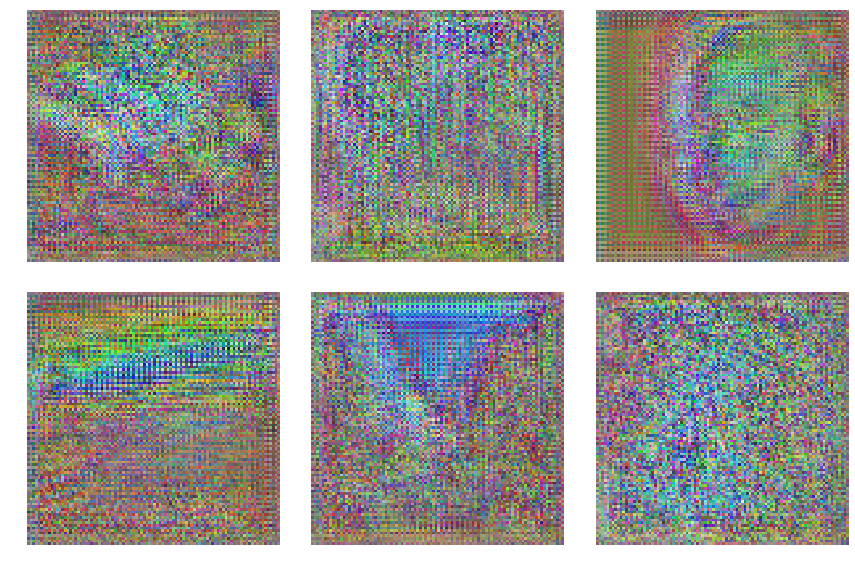

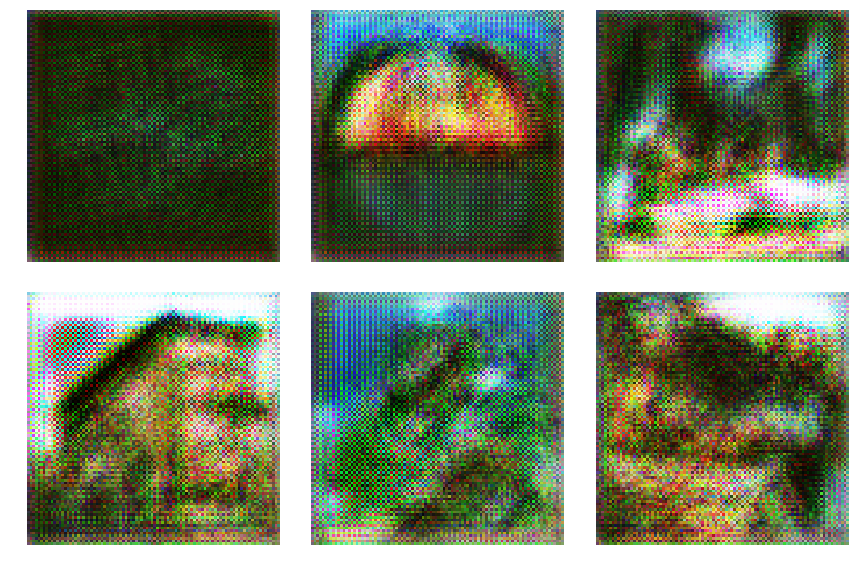

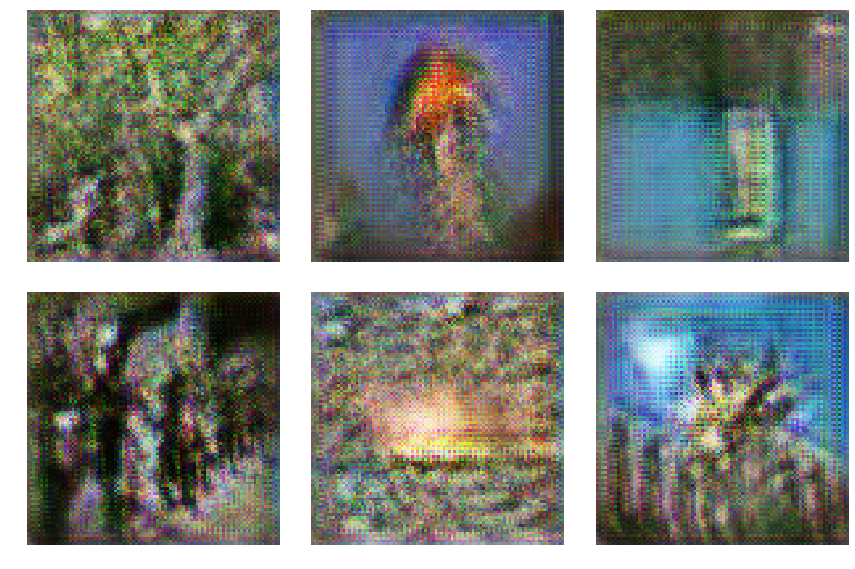

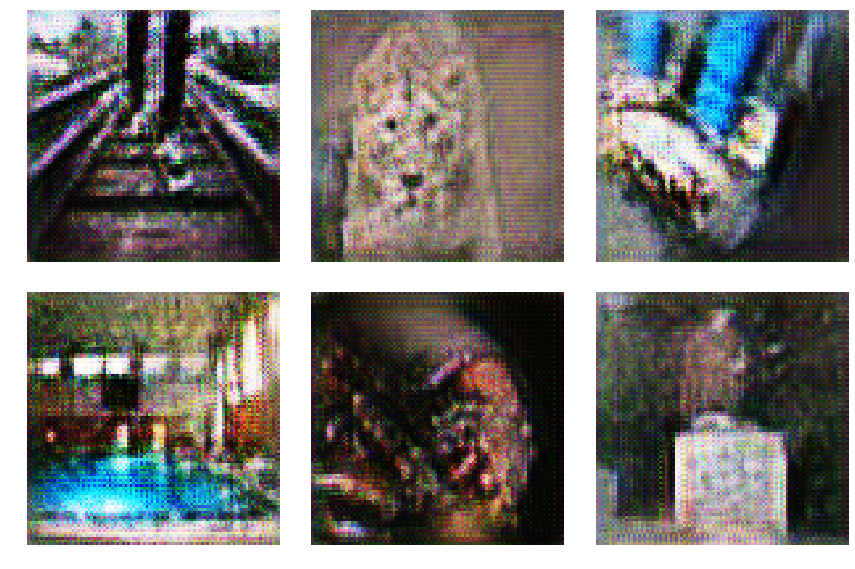

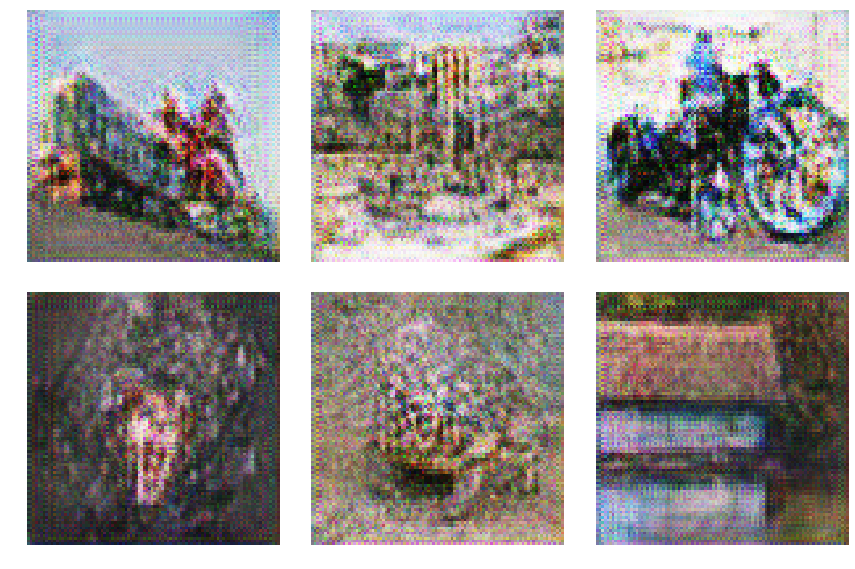

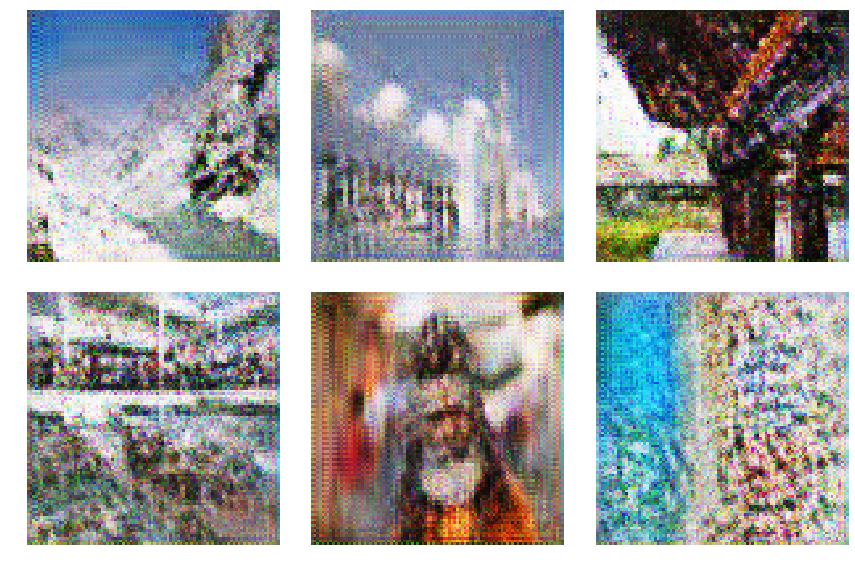

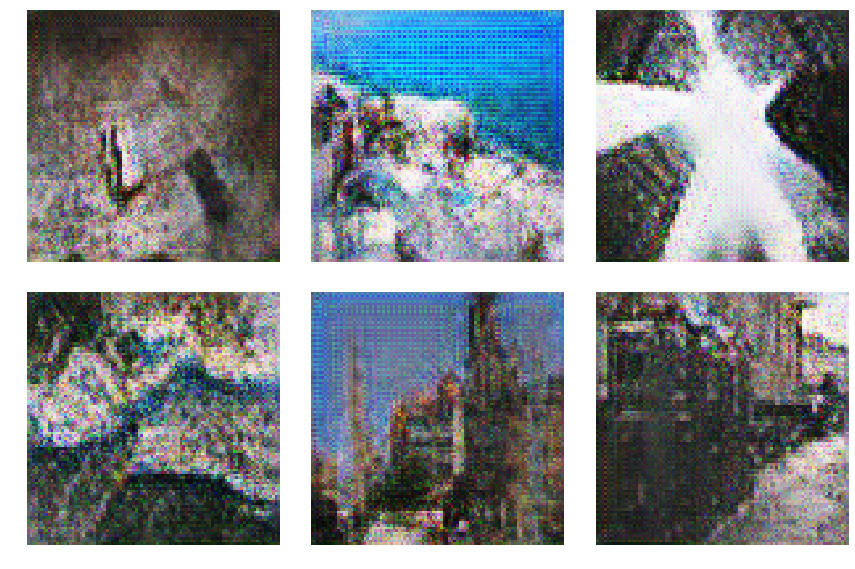

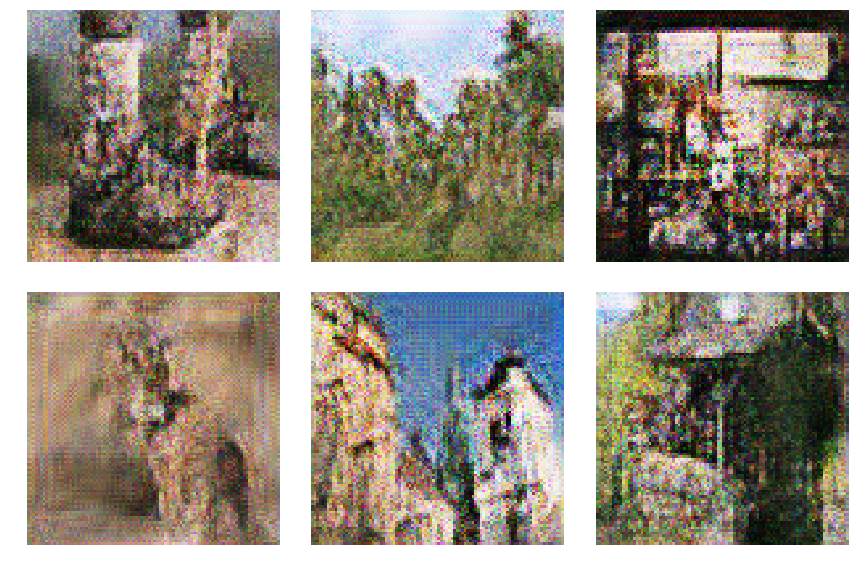

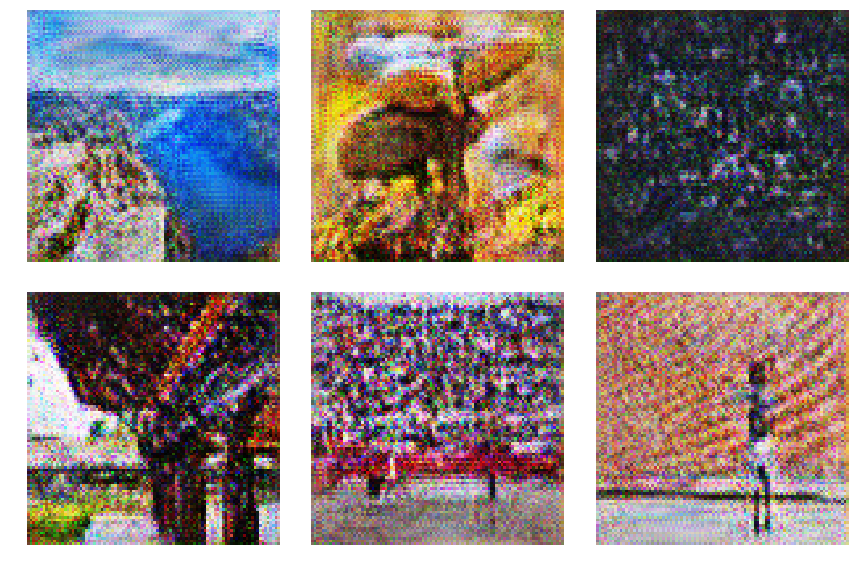

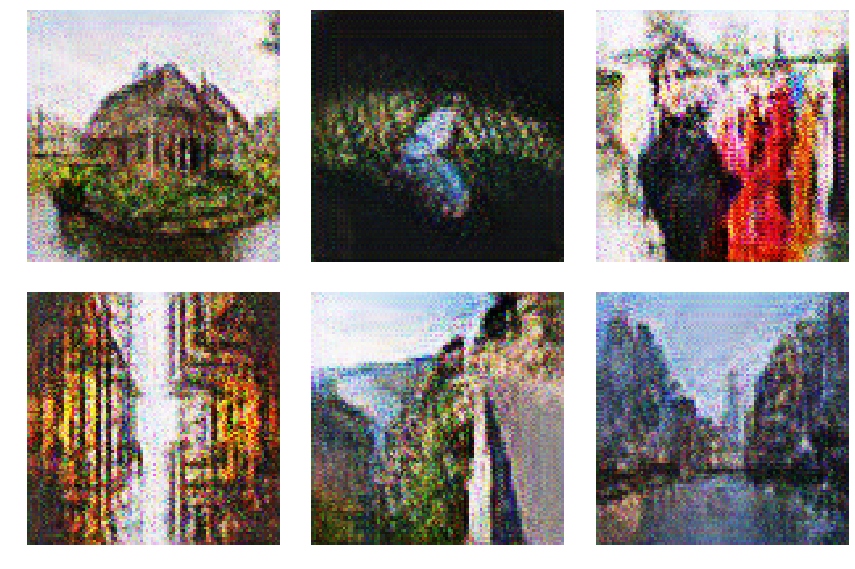

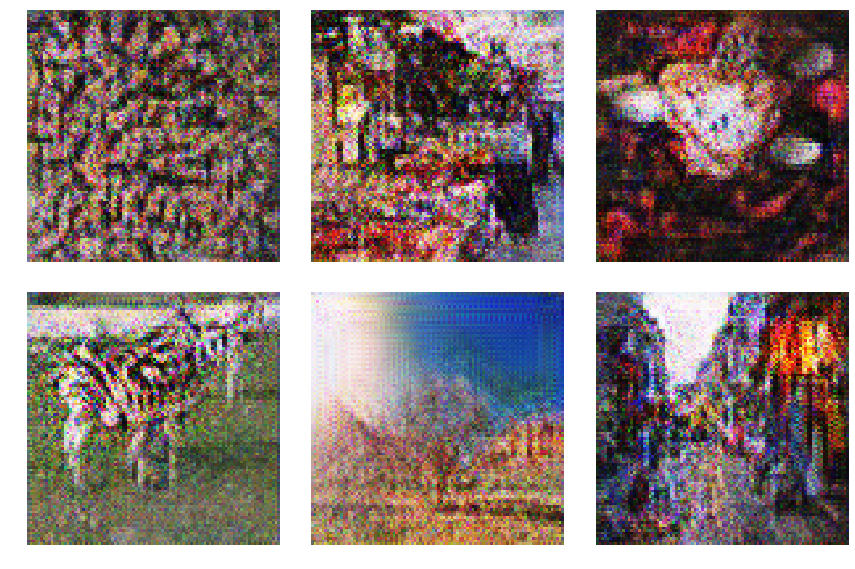

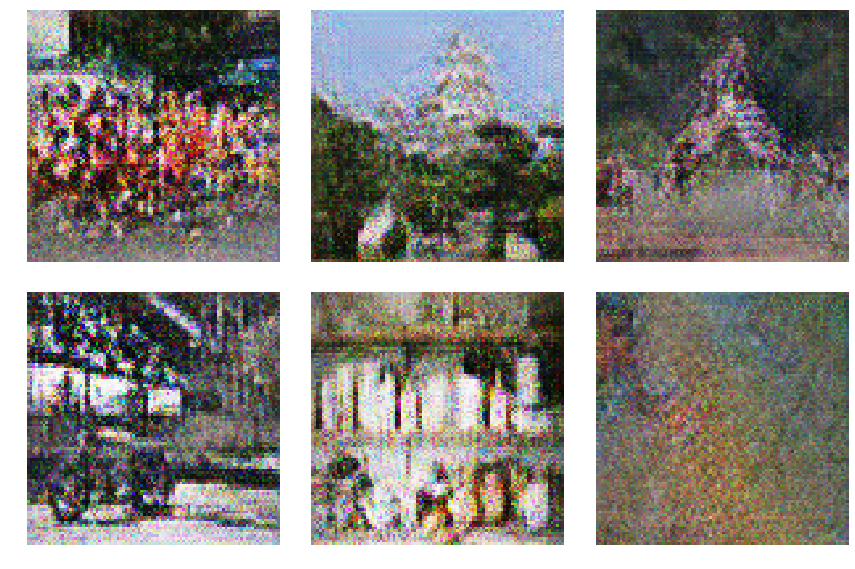

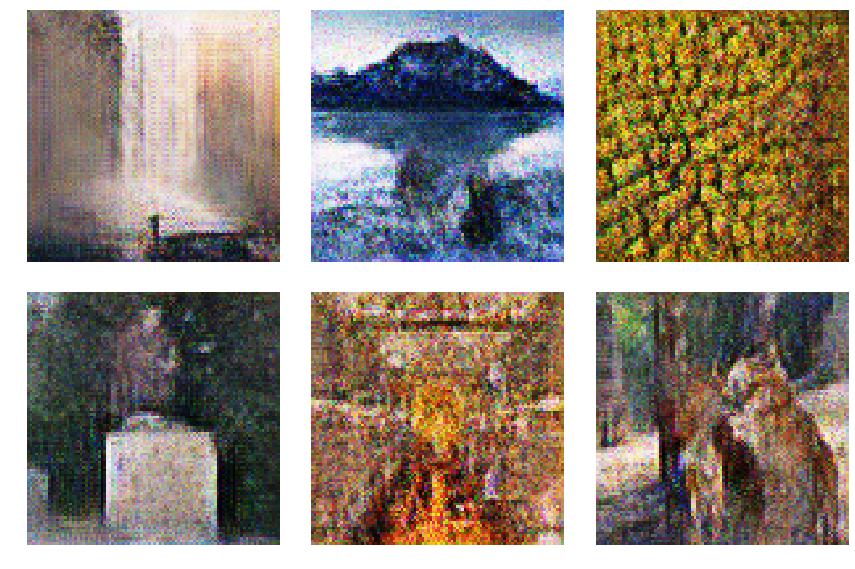

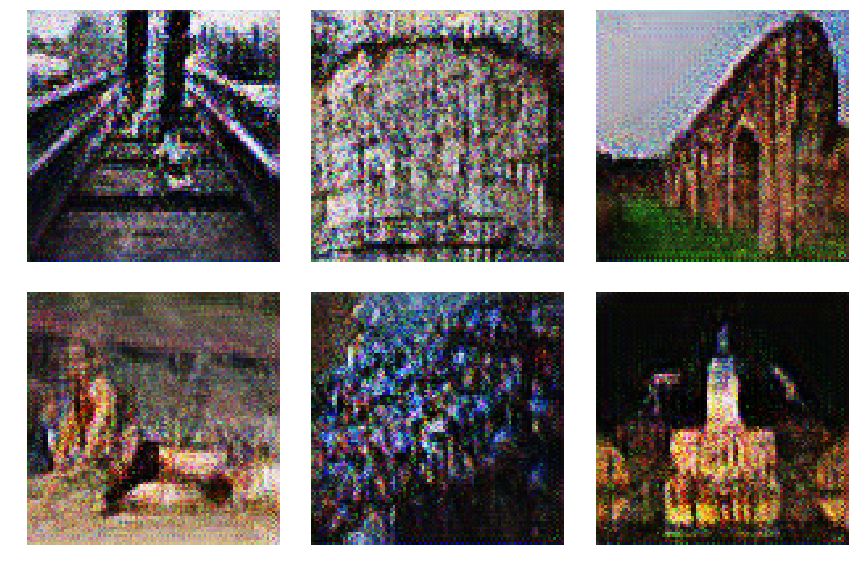

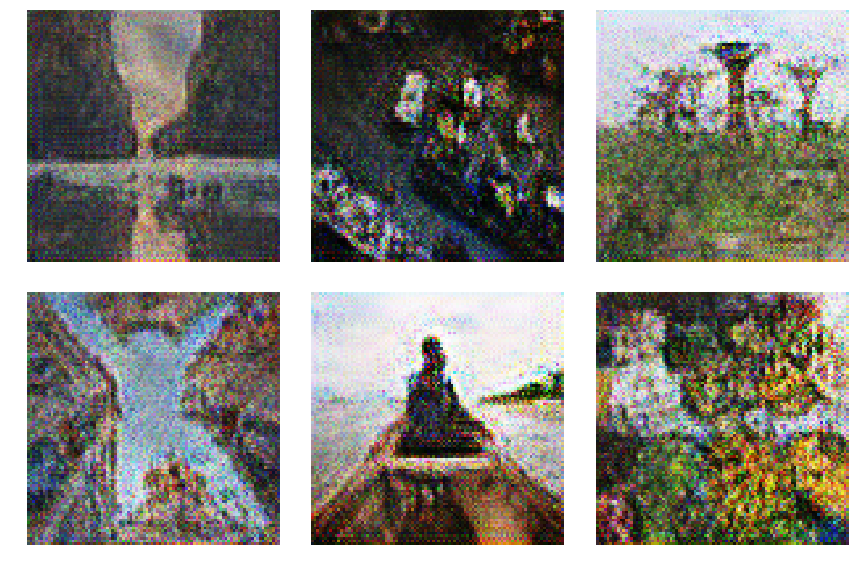

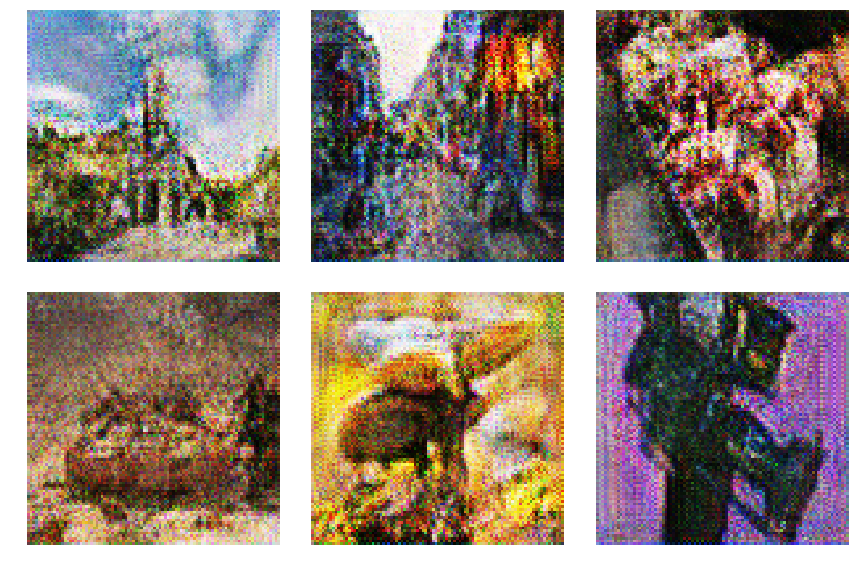

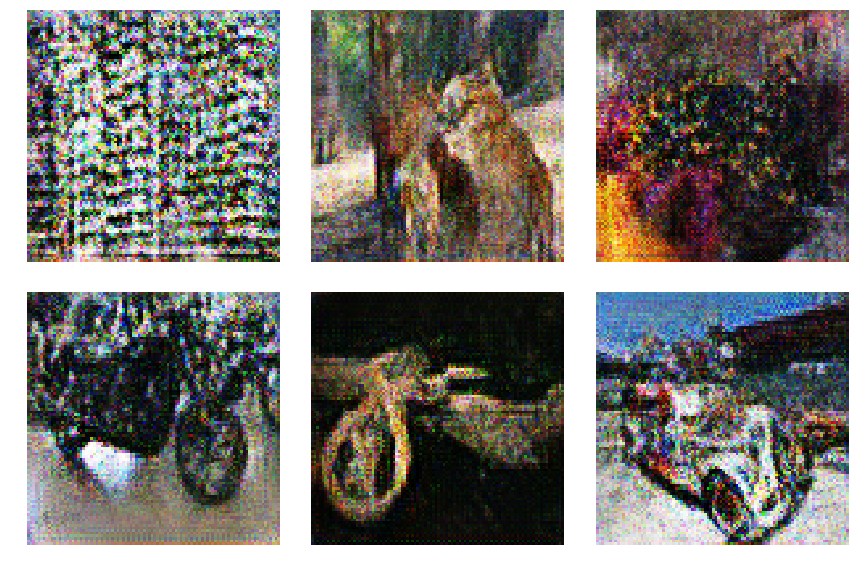

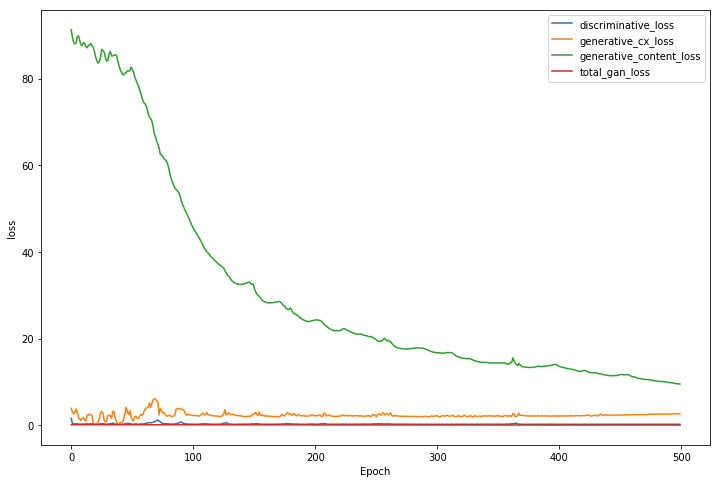

In [11]:
train()